In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import qnmfits

In [2]:
sim = qnmfits.SXS(ID=305, zero_time=(2,2))

# reinterpolate the simulation to regular time steps
times = np.arange(-50, 100, 0.1)
for (l,m) in list(sim.h.keys()):
    re_part = interp1d(sim.times, sim.h[(l,m)].real, kind='cubic')
    im_part = interp1d(sim.times, sim.h[(l,m)].imag, kind='cubic')
    sim.h[(l,m)] = re_part(times) + 1j*im_part(times)
sim.times = times

/Users/christophermoore/miniconda3/envs/qnmfits_likedev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


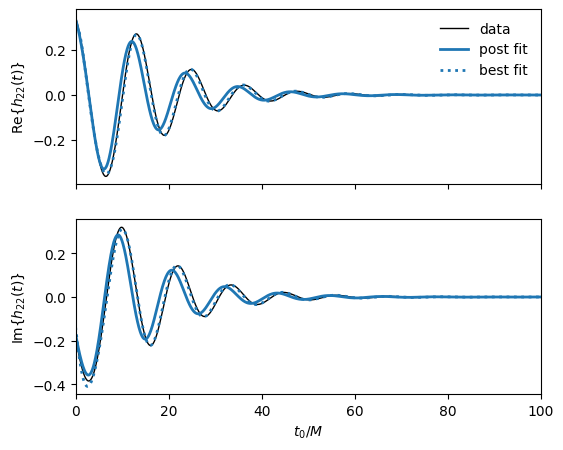

In [3]:
ell, m = 2, 2

times = sim.times
data = sim.h[(ell, m)]

modes = [(ell, m, n, 1) for n in range(3)]

Mf, chif = sim.Mf, sim.chif_mag

t0 = 0

best_fit = qnmfits.ringdown_fit(times, data, modes, Mf, chif, t0, t0_method='geq', T=100)

post_fit = qnmfits.likelihood_fit(times, data, modes, Mf, chif, t0, qnmfits.GPkernel, 
               GPkernel_kwargs={'timescale': 1., 'sigma':3.0e-3, 'jitter':1.0e-6}, 
               t0_method='geq', T=100)

fig, ax = plt.subplots(nrows=2, figsize=(6, 5) , sharex=True)

ax[0].plot(post_fit['model_times'], post_fit['data'].real, color='k', lw=1, label='data')
ax[0].plot(post_fit['model_times'], post_fit['model'].real, color='C0', ls='-', lw=2, label='post fit')
ax[0].plot(best_fit['model_times'], best_fit['model'].real, color='C0', ls=':', lw=2, label='best fit')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel(r'$\mathrm{Re}\{h_{22}(t)\}$')

ax[1].plot(post_fit['model_times'], post_fit['data'].imag, color='k', lw=1, label='data')
ax[1].plot(post_fit['model_times'], post_fit['model'].imag, color='C0', ls='-', lw=2, label='post fit')
ax[1].plot(best_fit['model_times'], best_fit['model'].imag, color='C0', ls=':', lw=2, label='best fit')
ax[1].set_xlim(0, 100)
ax[1].set_xlabel(r'$t_0/M$')
ax[1].set_ylabel(r'$\mathrm{Im}\{h_{22}(t)\}$')

ax[0].legend(frameon=False)
plt.show()

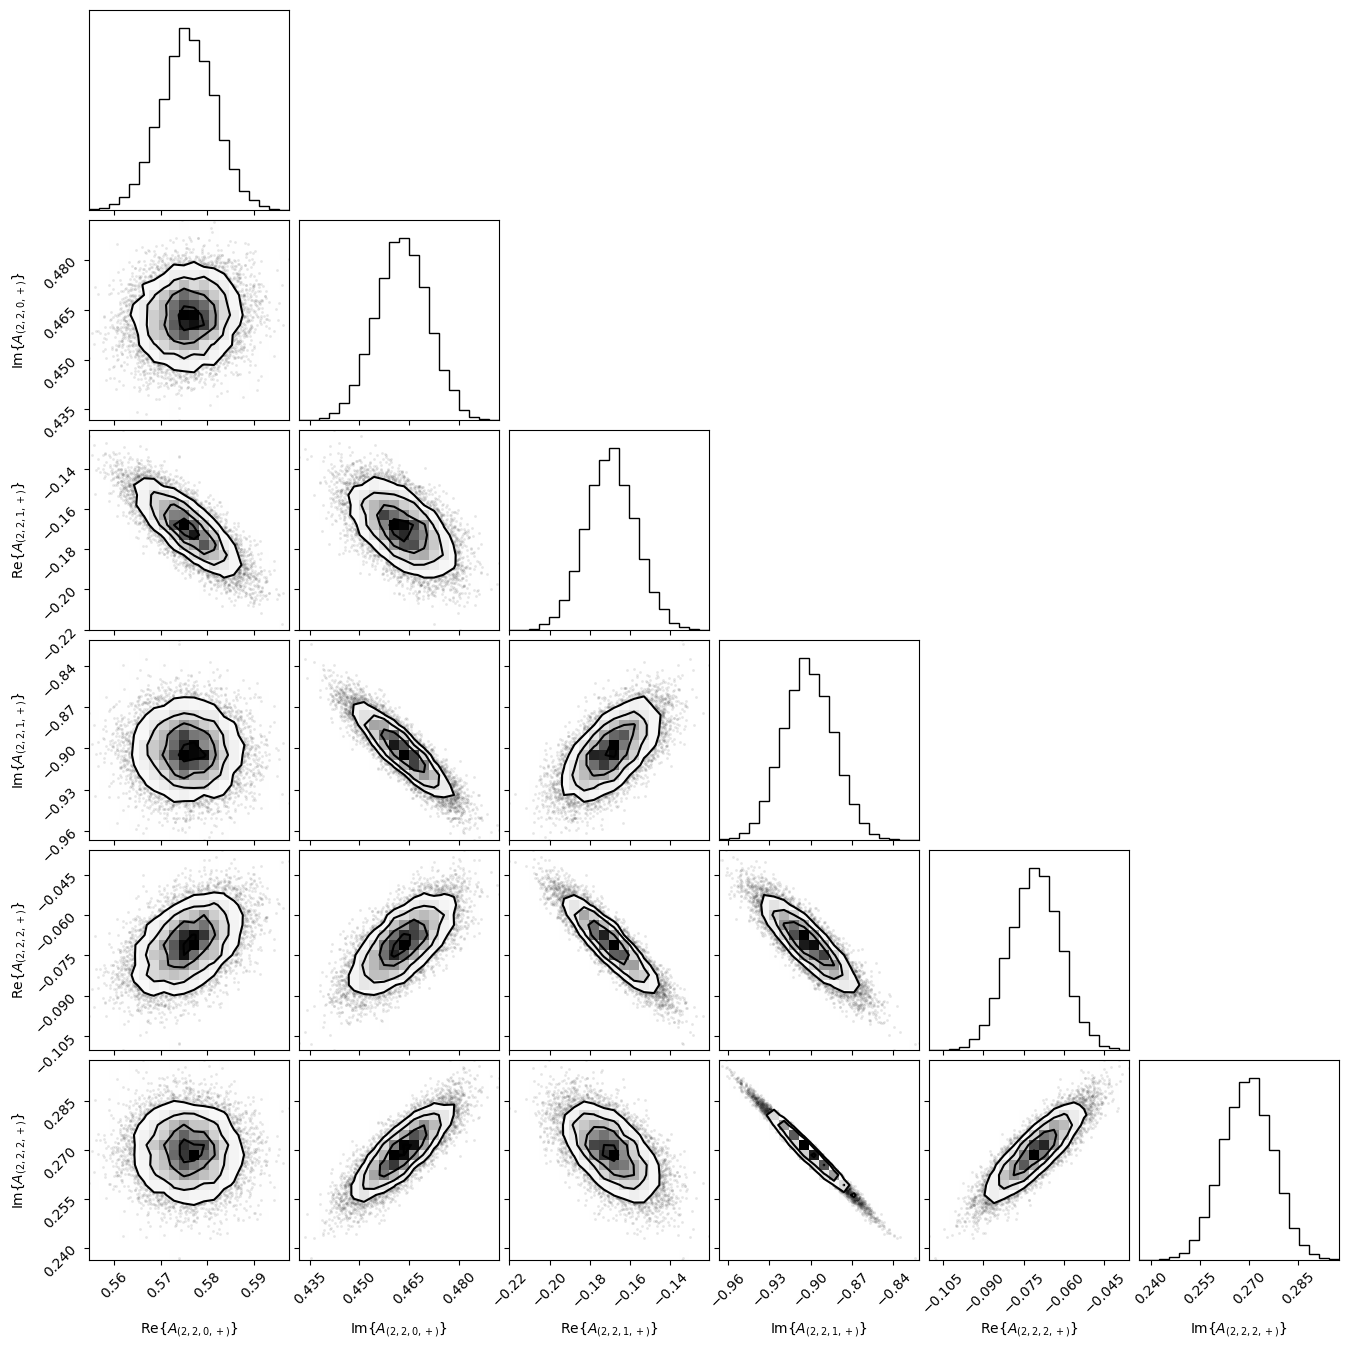

In [7]:
from corner import corner
from scipy.stats import multivariate_normal

dist = multivariate_normal(mean=np.vstack((post_fit['C'].real, post_fit['C'].imag)).reshape((-1,),order='F'), 
                           cov=post_fit['FM_post_inv'], allow_singular=True)
samples = dist.rvs(size=10000)

corner(samples, 
       labels=['$\\mathrm{'+part+'}\\{A_{(2,2,'+str(n)+',+)}\\}$' for n in range(len(post_fit['C'])) for part in ['Re', 'Im']],
       truths=np.zeros(2*len(post_fit['C'])))

plt.show()